In [32]:
from imprint.nb_util import setup_nb

# setup_nb is a handy function for setting up some nice plotting defaults.
setup_nb()
import scipy.stats
import matplotlib.pyplot as plt

import imprint as ip
import numpy as np
import jax
from scipy.special import expit, logit


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
#grid = ip.cartesian_grid(
#        [-3, -3], [3, 3], n=[10, 10], prune=True, null_hypos=[ip.hypo("theta0 < "+str(logit(0.5))), ip.hypo("theta1 <" +str(logit(0.7)))]
    )
#lam = 0.025
#x = expit(grid.df["theta0"] - grid.df["radii0"])*0.4 + 0.6*expit(grid.df["theta1"] - grid.df["radii1"]) < 0.5*0.4 + 0.7*0.6
#grid.df["null_truth2"] = x
#type(grid.df)
#plt.scatter(grid.df["theta0"], grid.df["theta1"], c = grid.df["null_truth2"])

IndentationError: unexpected indent (635866281.py, line 3)

In [ ]:
#First building a function which operates on a single grid point
def closed_test(pvalues, alpha):
    rejected = [False]*len(pvalues)
    for i in range(len(pvalues)):
        curr_rejections = sum(rejected)
        curr_thresh = alpha/(len(pvalues)-sum(rejected))
        rejected = [rejected[i] or pvalues[i] <= curr_thresh for i in range(len(pvalues))]
        if sum(rejected) == len(pvalues):
            break
    return  rejected

In [ ]:
#Next, we simultaneously operate on all of the grid-points, and return a list of rejections
def closed_test_half(pvalues, alpha):
    #initialize rejections to false, with shape = shape(pvalues)
    rejected = full_like(pvalues, False)
    for i in range(shape(pvalues)[1]):
        sumrejections = np.sum(rejected,axis=1)
        curr_thresh = alpha/(shape(pvalues)[1]-sumrejections)
        rejected = rejected or pvalues <= curr_thresh[:,None]
        print(rejected)
    return  rejected

In [ ]:
def closed_test_full(pvalues, alpha):
    #initialize rejections to false,
    #will have shape = (#criticalvalues, #hypotheses, #gridpoints, #sims)
    temp = pvalues[None,:,:,:]+alpha[:,None,:,:]
    #temp.shape is (10, 3, 360, 100)
    rejected = np.full_like(temp, False) 
    # alpha.shape is 10, 360, 100
    epsilon = 1e-10
    for i in range(pvalues.shape[0]):
        sumrejections = np.sum(rejected,axis=1)
        curr_thresh = alpha/(epsilon+pvalues.shape[0]-sumrejections)
        rejected = np.less_equal(pvalues[None,:,:,:], curr_thresh[:,None,:,:])
    return  rejected

In [ ]:
class BinomialClosed:
    def __init__(self, seed, max_K, *, n):
        self.family = "binomial"
        self.family_params = {"n": n[0]}
        self.n=n
        key = jax.random.PRNGKey(seed)
        splitkeys = jax.random.split(key, num=2)
        self.samples_arm1 = jax.random.uniform(
            splitkeys[1], shape=(max_K, n[1]), dtype=np.float32
        )
        
        self.samples_arm0 = jax.random.uniform(
            splitkeys[0], shape=(max_K, n[0]), dtype=np.float32
        )

    def sim_batch(self, begin_sim, end_sim, theta, null_truth, detailed=False):
        p = expit(theta)
        # successes is a 2-dimensional array of shape: (n_tiles, n_sims = K)
        successes1 = np.sum(self.samples_arm1[None, begin_sim:end_sim, :] < p[:, None, None, 1],axis =2)
        successes0 = np.sum(self.samples_arm0[None, begin_sim:end_sim, :] < p[:, None, None, 0],axis =2)
        phat1 = successes1 / self.n[1]
        phat0 = successes0 / self.n[0]
        #pooledphat = (phat1*self.n[1] + phat0*self.n[0]) / (self.n[1] + self.n[0])
        zstat0 = (phat0 - 0.5) / np.sqrt(phat0 * (1 - phat0) / self.n[0])
        zstat1 = (phat1 - 0.7)/ np.sqrt(phat1 * (1 - phat1) / self.n[1])
        zstatcombo = (0.4 * (phat0 -0.5)+ 0.6* (phat1- 0.7)) / np.sqrt( 0.4**2 * phat0*(1-phat0)/ self.n[0] + 0.6**2 * phat1*(1-phat1)/ self.n[1])
        pvalues = 1-scipy.stats.norm.cdf([zstat0,zstat1,zstatcombo])
        pvalues = np.nan_to_num(pvalues) + ([phat0,phat1,phat1 * phat0] == np.full_like(pvalues,0))
        # The following needs to be vectorized
        possible_critical_values = np.sort(np.concatenate((pvalues,2*pvalues,3*pvalues,np.full_like(pvalues[1,:,:],100)[None,:,:])), axis = 0)
        #next we need to apply closed testing to the 3 pvalues for EVERY choice in the list of possible critical values
        rejections_list = closed_test_full(pvalues, possible_critical_values)
        nullstatus = np.asarray(np.transpose(null_truth))
        falserejs = np.logical_and(rejections_list,nullstatus[None,:,:,None])
        fwer = np.any(falserejs, axis = 1)
        #some akwardness to cause the following minimum to give us the right answer
        temp = 1000*(1 - fwer) + fwer*possible_critical_values
        out = np.min(temp, axis=0)
        #out.shape : n_tiles, n_sims
        return out


In [ ]:
grid = ip.cartesian_grid(
        [-0.5, 0], [1.5, 2], n=[20, 20], prune=True, null_hypos=[ip.hypo("theta0 < "+str(logit(0.5))), ip.hypo("theta1 <" +str(logit(0.7)))]
    )
x=BinomialClosed(0, 2, n = [100,100])
outs = x.sim_batch(0, 2, theta = grid.get_theta(), null_truth=grid.df[["null_truth0", "null_truth1", "null_truth2"]])


NameError: name 'grid' is not defined

In [ ]:
grid = ip.cartesian_grid(
        [-0.5, 0], [1.5, 2], n=[100, 100], prune=True, null_hypos=[ip.hypo("theta0 < "+str(logit(0.5))), ip.hypo("theta1 <" +str(logit(0.7)))]
    )
x = expit(grid.df["theta0"] - grid.df["radii0"])*0.4 + 0.6*expit(grid.df["theta1"] - grid.df["radii1"]) < 0.5*0.4 + 0.7*0.6
grid.df["null_truth2"] = x
type(grid.df)
y = ip.validate(BinomialClosed, grid, lam = 0.025, K=10000, model_kwargs=dict(n=[100,100]))


(5775, 4)

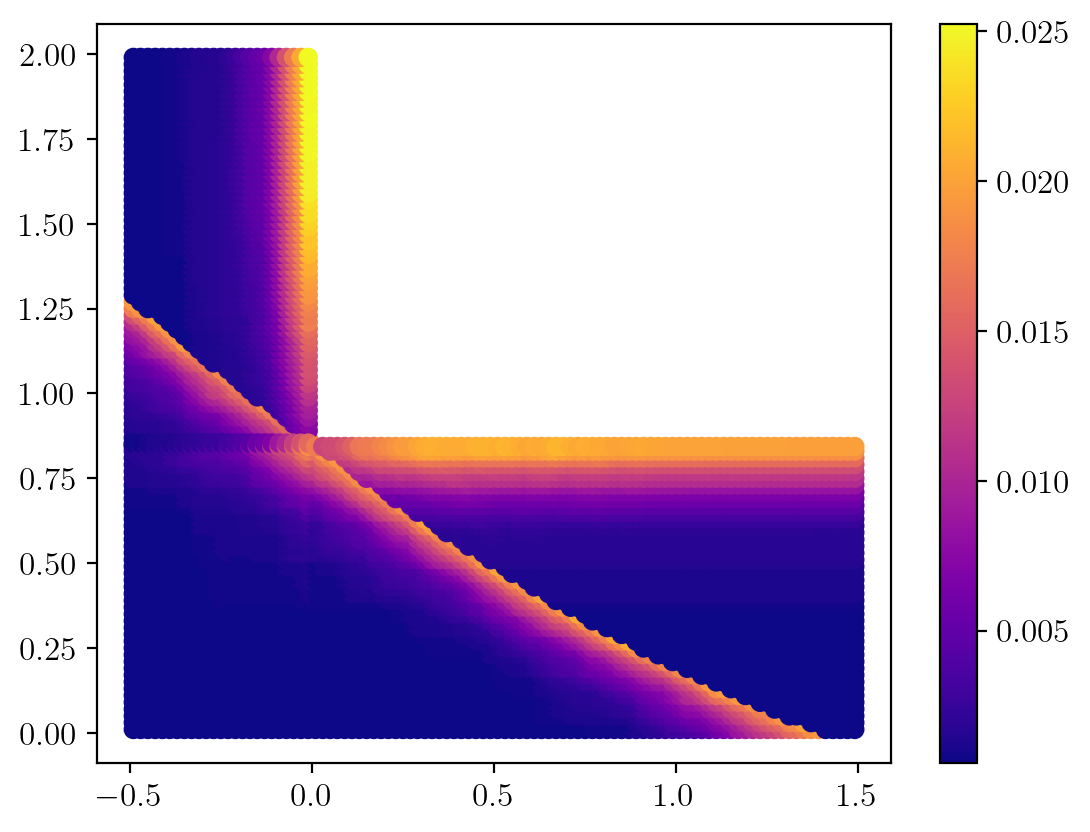

In [ ]:
plt.scatter(grid.df["theta0"], grid.df["theta1"], c=y["tie_bound"])
plt.colorbar()

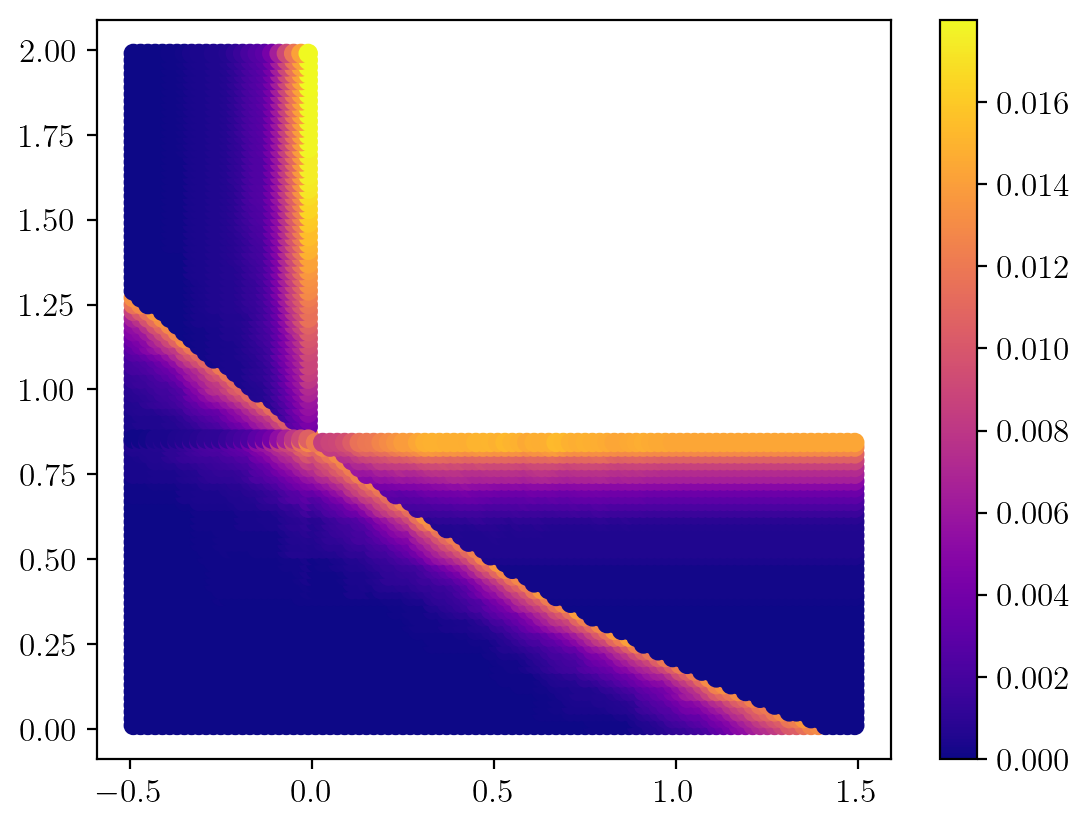

In [ ]:
plt.scatter(grid.df["theta0"], grid.df["theta1"], c=y["tie_est"])
plt.colorbar()

In [43]:
grid = ip.cartesian_grid(
        [-0.5, 0], [1.5, 2], n=[200, 200], prune=True, null_hypos=[ip.hypo("theta0 < "+str(logit(0.5))), ip.hypo("theta1 <" +str(logit(0.7)))]
    )
x = expit(grid.df["theta0"] - grid.df["radii0"])*0.4 + 0.6*expit(grid.df["theta1"] - grid.df["radii1"]) < 0.5*0.4 + 0.7*0.6
grid.df["null_truth2"] = x
z = ip.validate(BinomialClosed, grid, lam = 0.025, K=50000, model_kwargs=dict(n=[100,100]))

In [37]:
#min(z["lams"]) #0.027, about what we'd expect! Can be shrunk a lot more with smaller gridding + more simsize

0.027130883187055588

In [46]:
z

,tie_sum,tie_est,tie_cp_bound,tie_bound
0,0,0.00000,0.000092,0.000107
1,0,0.00000,0.000092,0.000107
2,0,0.00000,0.000092,0.000107
3,0,0.00000,0.000092,0.000107
4,0,0.00000,0.000092,0.000107
...,...,...,...,...
22995,779,0.01558,0.016917,0.018257
22996,779,0.01558,0.016917,0.018255
22997,779,0.01558,0.016917,0.018253
22998,779,0.01558,0.016917,0.018251


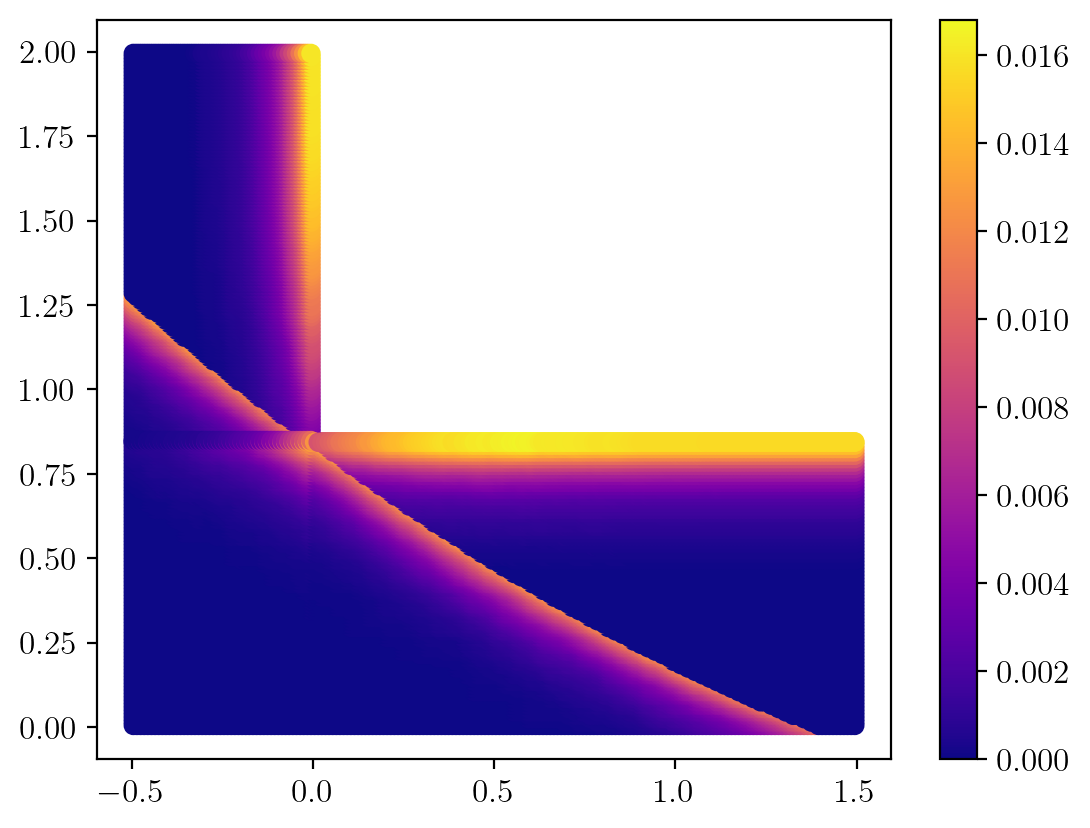

KeyError: 'lams'

In [49]:
plt.scatter(grid.df["theta0"], grid.df["theta1"], c=z["tie_est"])
plt.colorbar()
plt.show()
plt.hist(z["lams"], bins = 100)